In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import string
import re

%matplotlib inline

In [2]:
# df = pd.read_csv('test.csv', sep='-', names=['position', 'band', 'song'])
# df['year'] = ''
# df = df.applymap(lambda x: x.lstrip().rstrip() if type(x) == str else x)

# def get_first_letter(band):
#     band = band.lstrip()
    
#     if band[:3].lower() == 'the':
#         band = band[3:].lstrip()
    
#     return band[0]

# df['first_letter'] = df.band.map(get_first_letter)

# df.song = df.song.map(lambda x: x.replace("’", "'"))
# df.band = df.band.map(lambda x: x.replace("’", "'"))

# df.song = df.song.map(lambda x: x.replace("‘", "'"))
# df.band = df.band.map(lambda x: x.replace("‘", "'"))

# df.loc[df.song.str.contains('8675309'), ['song']] = '867-5309/JENNY'
# df.loc[df.band.str.contains('BACHMAN'), ['band']] = 'BACHMAN-TURNER OVERDRIVE'

In [20]:
df = pd.read_csv('500_mais_with_year.csv', index_col=0, dtype={'year': str, 'decade': str})
df.year.fillna('', inplace=True)

In [15]:
df.to_csv('500_mais_with_year.csv')

In [21]:
df.head()

,position,band,song,first_letter,year,decade
0,500,AUDIOSLAVE,COCHISE,A,2002,2000s
1,499,BIG COUNTRY,IN A BIG COUNTRY,B,1983,1980s
2,498,LENNY KRAVITZ,LOW,L,2018,2010s
3,497,AC/DC,HARD AS A ROCK,A,1995,1990s
4,496,U2,BEAUTIFUL DAY,U,2000,2000s


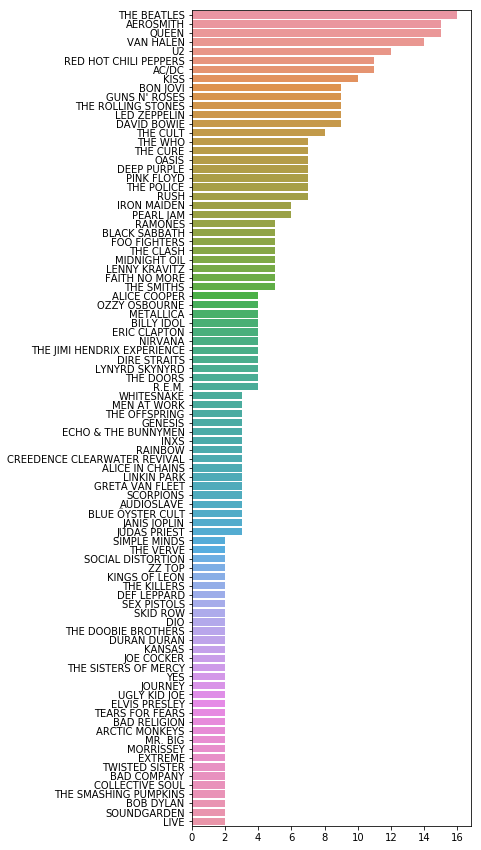

In [6]:
series = df.band.value_counts()[df.band.value_counts() > 1]

plt.figure(figsize=(5, 15))
sns.barplot(series.values, series.index);

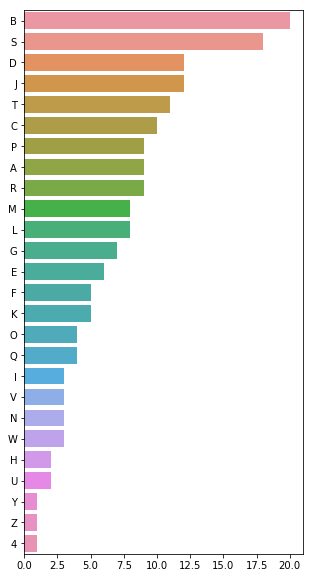

In [7]:
series = df.groupby(['first_letter', 'band']).position.count().reset_index().first_letter.value_counts()

plt.figure(figsize=(5, 10))
sns.barplot(series.values, series.index);

In [6]:
exclusions = [
    "a", "an", "the",  # Articles
    "and", "but", "or",  "by", "nor", "yet", "so",  # Conjunctions
    "about", "above", "across", "after", "against", "along", "among", "around", "at", "before",  # Prepositions
    "behind", "between", "beyond", "but", "by", "concerning", "despite", "down", "during",
    "except", "following", "for", "from", "in", "including", "into", "like", "near", "of",
    "off", 
#     "on", 
#     "out", 
    "over", "plus", "since", "through", "throughout", "to", "towards",
    "under", "until", "up", "upon", "with", "within", 
#     "without",
    "my", "as" # others
]
 
def TitleCase(curText):
    curText = string.capwords(curText)
    words = curText.split()
    for index, word in enumerate(words):
        if len(word) > 1 and not word[0].isalpha() and word[1].isalpha():
            words[index] = word[0] + word[1:].capitalize()
        if index != 0 and index != len(words) - 1 and word.lower() in exclusions:
            words[index] = word.lower()
    curText = ' '.join(words)
    return curText

In [7]:
def make_request(URL, band_name):
    URL = URL.replace('?', '%3F')
    r = requests.get(URL)
    try:
        assert r.status_code == 200
        
        band_name_pieces = re.split("[\'Öÿ&ö]+", band_name)
        for piece in band_name_pieces:
            assert piece.lower() in str(r.content).lower()
        if len(band_name_pieces) == 1:
            assert 'For the {} song, see'.format(band_name).lower() \
                                             not in str(r.content).lower() 
#         else:
#             assert 'For the {} song, see'.format(band_name).lower() \
#                                              not in str(r.content).lower() 
#             assert 'For the {} song, see'.format(band_name).lower() \
#                                              not in str(r.content).lower() 
        return r
    except AssertionError:
        raise

def get_soup(URL, band_name):
    try:
        r = make_request(URL, band_name)
        soup = BeautifulSoup(r.content, 'html5lib')
        soup = soup.find_all(class_="infobox vevent")[0]
        return soup
    except (IndexError, AssertionError):
        raise
        
def find_song_year(song_name, band_name, year=''):
    if year != '':
        return year
    
    song_name = "_".join(TitleCase(song_name).split())
    # hardcoded:
    if 'jenny' in song_name:
        song_name = song_name.replace('j', 'J')
    if 'You?' in song_name:
        song_name = song_name.replace('?', '')
#     if 'Usa' in song_name:
#         song_name = song_name.replace('Usa', 'U.S.A.')
#     if "U.s.a." in song_name:
#         song_name = song_name.replace('U.s.a.', 'U.S.A.')
    if "U.s.s.r" in song_name:
        song_name = song_name.replace('U.s.s.r.', 'U.S.S.R.')
#     if "N.i.b." in song_name:
#         song_name = song_name.replace('N.i.b.', 'N.I.B.')
#     if "T.n.t." in song_name:
#         song_name = song_name.replace('T.n.t.', 'T.N.T.')
#     if "U.k." in song_name:
#         song_name = song_name.replace('U.k.', 'U.K.')
        
    pat = r'(?<=\.).+?(?=\.)'  #See Note at the bottom of the answer
    for match in re.findall(pat, song_name):
        song_name = song_name.replace('.{}.'.format(match), '.{}.'.format(match.upper()))
    
    year = ''
    base_URL = "https://en.wikipedia.org/wiki/{}".format(song_name)
    band_name = TitleCase(band_name)
    # hardcoded:
    if 'Ac/dc' in band_name:
        band_name = band_name.replace('Ac/dc', 'AC/DC')
    if 'Inxs' in band_name:
        band_name = band_name.replace('Inxs', 'INXS')
    
    try:
        URL = base_URL
        soup = get_soup(URL, band_name)
    except (IndexError, AssertionError):
        try:
            URL = base_URL + '_(song)'
            soup = get_soup(URL, band_name)
        except (IndexError, AssertionError):
            try:
                URL = base_URL + '_({}_song)'.format("_".join(band_name.split()))
                soup = get_soup(URL, band_name)
            except (IndexError, AssertionError):
                print('URL: {}, band_name: {}'.format(URL, band_name))
                return year
        
    try:
        released = soup.find_all('th', text='Released')[0]
    except IndexError:
        print('couldnt find Released at URL {}'.format(URL))
        return year
        
    try:
        released_date = released.find_next_siblings()[0]
#         released_date = released_date.text.split()
        released_date = re.split("[\ \[\](&nbsp;)]+", released_date.text)
    except IndexError:
        print('couldnt find released date at URL {}'.format(URL))
        return year
    
    for i in released_date:
        try:
            int(i)
            if len(i) == 4:
                year = i
        except:
            pass
    
    if year ==  '':
        print('couldnt find year at URL {}'.format(URL))
    
    return year

In [8]:
df['year'] = df.apply(lambda row: find_song_year(row.song, row.band, row.year), axis=1)

URL: https://en.wikipedia.org/wiki/Full_Circle_(Aerosmith_song), band_name: Aerosmith
URL: https://en.wikipedia.org/wiki/Not_Enough_(Van_Halen_song), band_name: Van Halen
URL: https://en.wikipedia.org/wiki/Take_Cover_(Mr._Big_song), band_name: Mr. Big
URL: https://en.wikipedia.org/wiki/In_the_Midnight_Hour_(The_Commitments_song), band_name: The Commitments
URL: https://en.wikipedia.org/wiki/Police_On_my_Back_(The_Clash_song), band_name: The Clash
URL: https://en.wikipedia.org/wiki/King_of_the_Mountain_(Midnight_Oil_song), band_name: Midnight Oil
URL: https://en.wikipedia.org/wiki/Shake_my_Tree_(Coverdale/page_song), band_name: Coverdale/page
URL: https://en.wikipedia.org/wiki/Sunday_Morning_(The_Bolshoi_song), band_name: The Bolshoi
URL: https://en.wikipedia.org/wiki/Flowers_by_the_Door_(T.s.o.l._song), band_name: T.s.o.l.
URL: https://en.wikipedia.org/wiki/Wild_Flower_(The_Cult_song), band_name: The Cult
URL: https://en.wikipedia.org/wiki/Forgotten_Years_(Midnight_Oil_song), band_name

In [24]:
df.year.value_counts()

1992    27
1991    24
1983    20
1993    18
1990    18
1984    18
1985    18
1980    17
1986    17
1989    15
1987    14
1979    14
1994    14
1973    14
1971    13
1977    13
1976    12
1981    12
1978    11
1974    11
1969    11
1997    11
1968    11
1970    10
1975    10
1996     9
1988     9
1972     9
1982     9
1967     8
2000     8
2003     8
1995     7
1965     6
1998     5
2001     5
2004     5
1963     4
1999     4
2005     4
2002     4
2018     3
2006     3
2008     2
2017     2
1964     2
2007     2
2012     2
1962     1
1966     1
1958     1
2014     1
2009     1
2011     1
1956     1
Name: year, dtype: int64

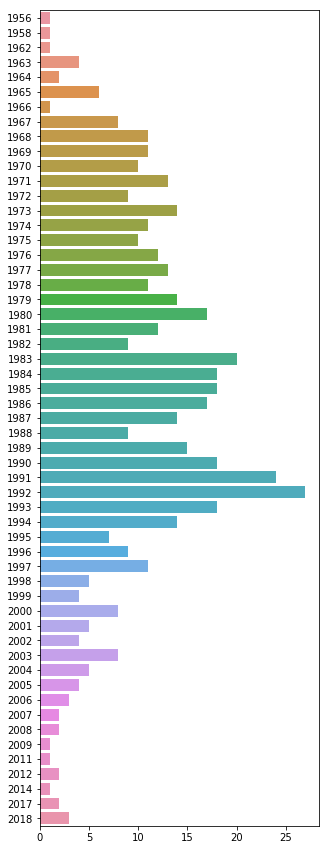

In [27]:
series = df.year.value_counts()

plt.figure(figsize=(5,15))
sns.barplot(series.values, series.index, orient='h');

In [16]:
df['decade'] = df.year.map(lambda x: str(int(x) // 10) + '0s' if x != '' else '')

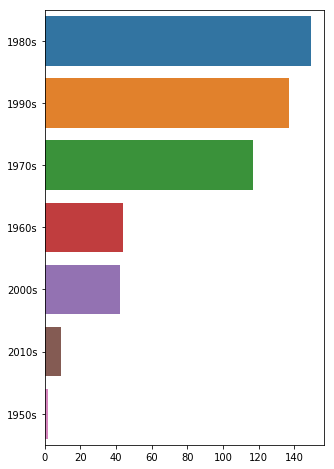

In [22]:
series = df.decade.value_counts()

plt.figure(figsize=(5,8))
sns.barplot(series.values, series.index)